# Contributions plot

contribution_plot is a method that displays violin or scatter plot.<br />
The purpose of these representations is to understand how a feature affects a prediction.<br />

<b>This tutorial </b>presents the different parameters you can<br />
use in *contribution_plot* to tune output.

Contents:
- Classification case: Specify the target modality to display.
- Sampling parameter
- Focus on a subset
- Violin or Scatter? Make your own choice


Data from Kaggle [Titanic](https://www.kaggle.com/c/titanic/data)

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

## Building Supervized Model 

Load Titanic data

In [2]:
from shapash.data.data_loader import data_loading
titanic_df, titanic_dict = data_loading('titanic')
y_df=titanic_df['Survived'].to_frame()
X_df=titanic_df[titanic_df.columns.difference(['Survived'])]

In [3]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,,
1,0,Third class,Braund Owen Harris,male,22.0,1,0,7.25,Southampton,Mr
2,1,First class,Cumings John Bradley (Florence Briggs Thayer),female,38.0,1,0,71.28,Cherbourg,Mrs
3,1,Third class,Heikkinen Laina,female,26.0,0,0,7.92,Southampton,Miss
4,1,First class,Futrelle Jacques Heath (Lily May Peel),female,35.0,1,0,53.10,Southampton,Mrs
5,0,Third class,Allen William Henry,male,35.0,0,0,8.05,Southampton,Mr


Load Titanic data

In [4]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

Train / Test Split + model fitting

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=7)

In [6]:
clf = XGBClassifier(n_estimators=200,min_child_weight=2).fit(Xtrain,ytrain)

#### First step: You need to Declare and Compile SmartExplainer 

In [7]:
from shapash.explainer.smart_explainer import SmartExplainer

In [8]:
response_dict = {0: 'Death', 1:' Survival'}

In [9]:
xpl = SmartExplainer(model=clf,
                     preprocessing=encoder, # Optional: compile step can use inverse_transform method
                     features_dict=titanic_dict, # Optional parameters
                     label_dict=response_dict) # Optional parameters, dicts specify labels 

In [10]:
xpl.compile(x=Xtest)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f836390ae20>


#### You can now display contribution plot :
you have to specify the feature you want to analyse. You can use column name, label or column number

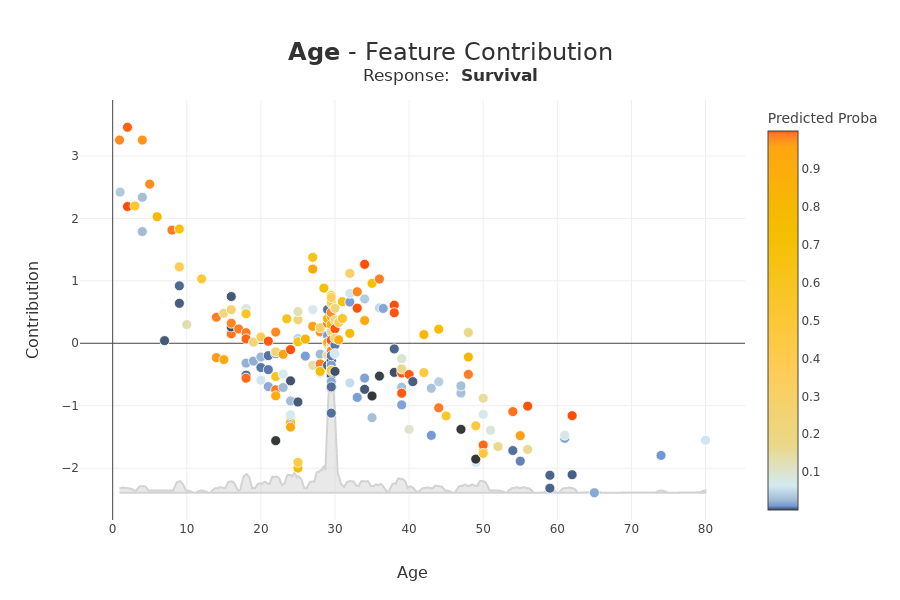

In [11]:
fig = xpl.plot.contribution_plot(col='Age')
fig.to_image(format="png")

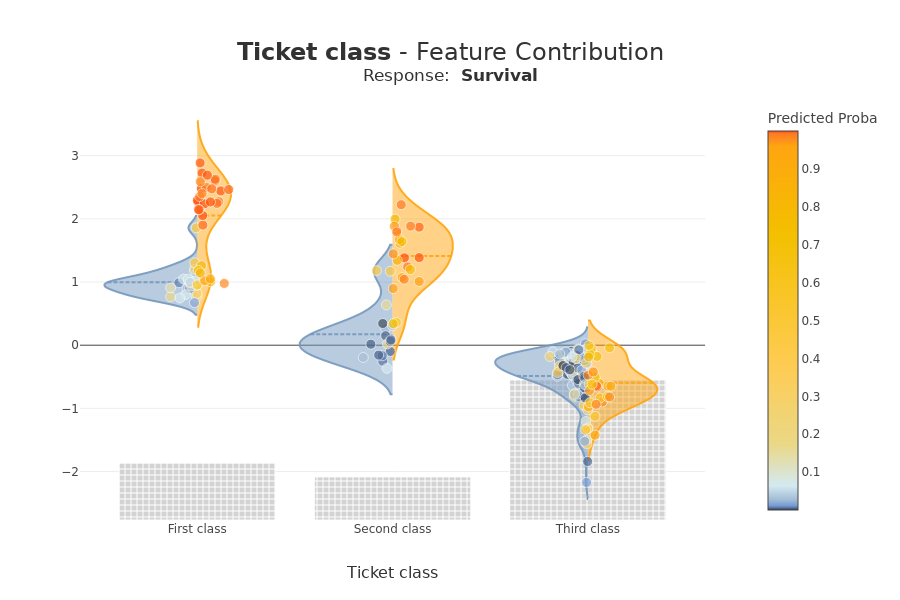

In [12]:
xpl.plot.contribution_plot(col='Pclass')

Ticket Class seems to affect the prediction of the mode: Third class negatively contributes to Survival.

#### Classification Case: Use label parameter to select the target modality you want to focus

with label parameter, you can specify explicit label or label number 

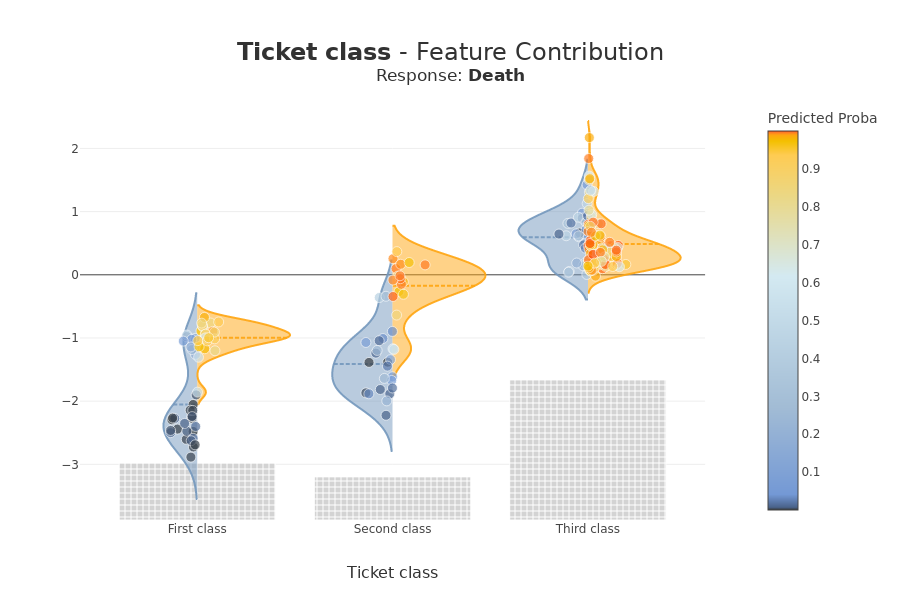

In [13]:
xpl.plot.contribution_plot(col='Pclass',label='Death')

## Add a prediction to better understand your model 

You can add your prediction with add or compile method

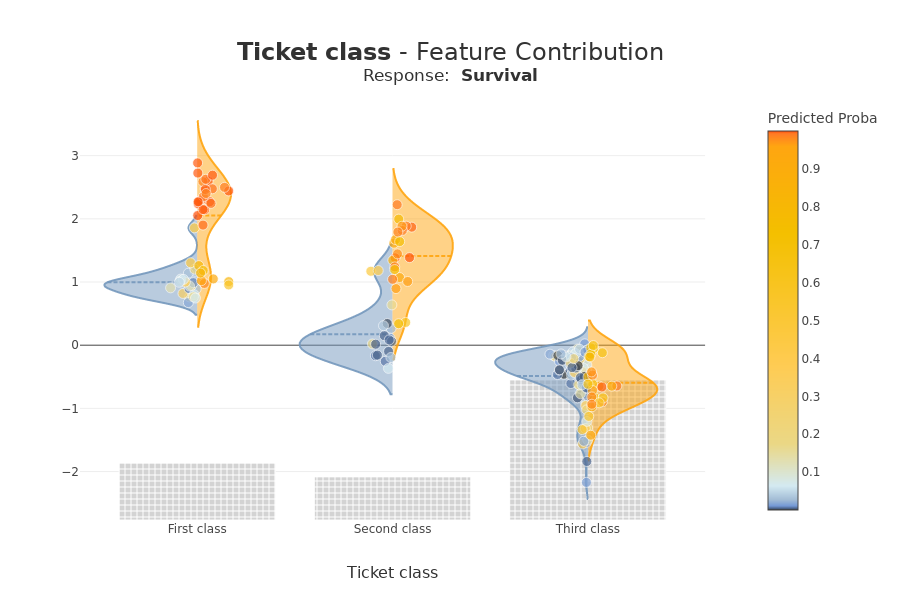

In [14]:
y_pred = pd.DataFrame(clf.predict(Xtest),columns=['pred'],index=Xtest.index)
xpl.add(y_pred=y_pred)
xpl.plot.contribution_plot(col='Pclass')

<b>When you add predict information, </b><br />
you can see that the contribution of *Ticket class* for *First class* and *Second class* seems to be different for people with Survive prediction(orange points), compared to others (grey points). 
The contributions for these two ticket classes can be correlated to the value of another characteristic.

Shapash Webapp can help you to refine your understanding of the model. You can navigate between the local and the global contributions.

For Third class, the 2 distributions seem to be close.

<b>NB: Multiclass Case</b> - This plot displays One Vs All plot

## Focus on a subset

With selection params you can specify a list of index of people you wand to focus

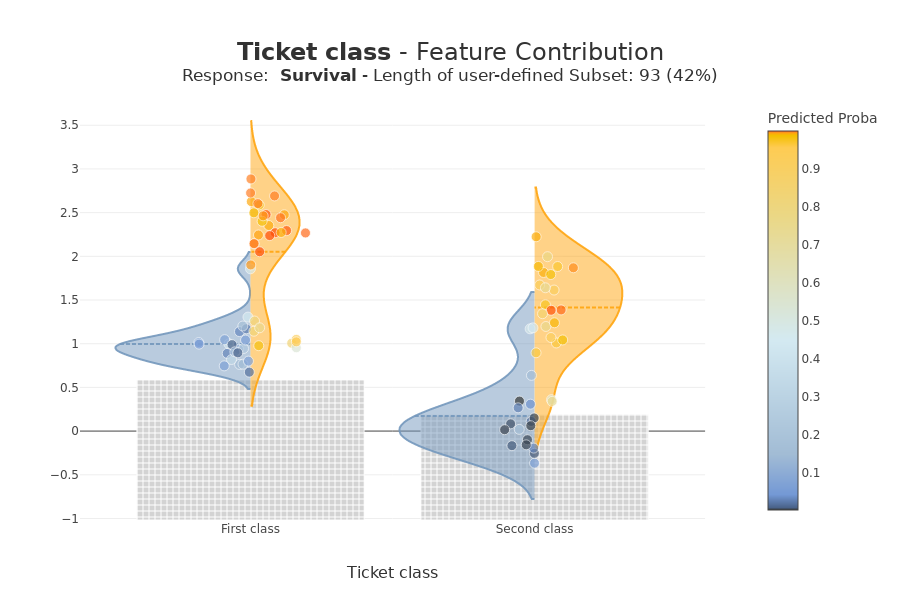

In [15]:
index = list(Xtest[xpl.x_init['Pclass'].isin(['First class','Second class'])].index.values)
xpl.plot.contribution_plot(col='Pclass',selection=index)

## Size of Random Sample

Method contribution_plot use random sample to limit the number of points displayed.
Default size of this sample is 2000, but you can change it with the parameter max_points:

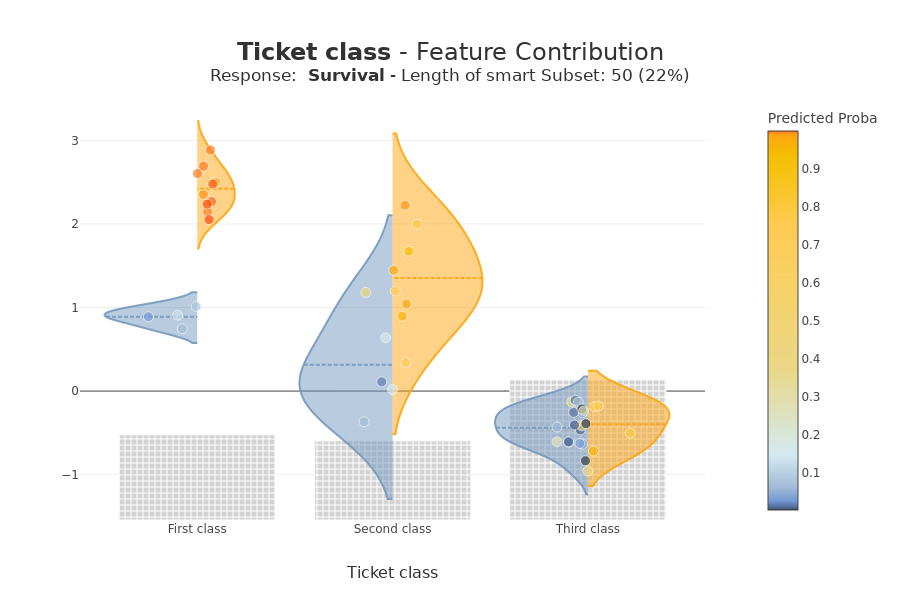

In [16]:
xpl.plot.contribution_plot(col='Pclass',max_points=50)

## Violin or Scatter plot?

contribution_plot displays a scatter point if the number of distinct values of the feature is greater than 10.
You can change this *violin_maxf* parameter :

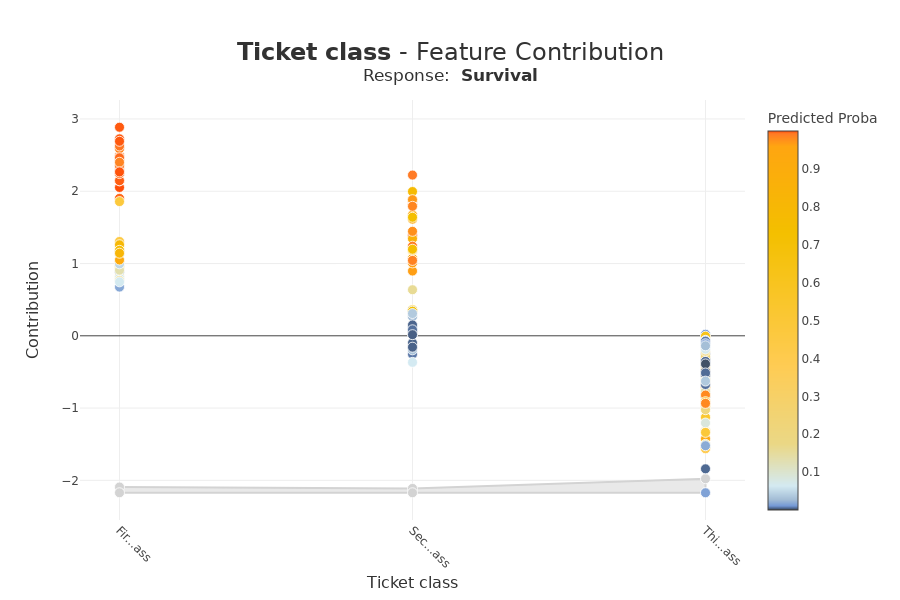

In [18]:
fig =xpl.plot.contribution_plot(col='Pclass',violin_maxf=2)